<p style="font-family: 'Courier New', Courier, monospace; font-size: 50px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: EXPLORATORY DATA ANALYSIS
</p>

<figure style="margin: 0 auto; width: fit-content;">
  <img src="lorawan_use_cases.png" alt="LoRaWAN Use Cases"/>
  <figcaption style="text-align: center; width: 100%; font-weight: bold;">
    Examples of LoRaWAN Indoor Use Cases
  </figcaption>
</figure>

In [42]:
# Libraries/Packages Used:
import pandas as pd                        # For data manipulation and analysis.
import numpy as np                         # For numerical computations and handling arrays.
import math                                # For mathematical functions.
import itertools                           # To cycle through general iterables.
from itertools import cycle                # To cycle through specific iterables like colors.
import matplotlib.pyplot as plt            # For creating static visualizations.
import matplotlib.gridspec as gridspec     # For grid layout management.
from matplotlib.lines import Line2D        # For creating custom lines in legends.
from matplotlib.patches import Patch       # For creating custom legend patches (e.g., colored boxes).
from collections import OrderedDict        # For maintaining order in unique legend entries.
import seaborn as sns                      # For statistical data visualization based on matplotlib.
import plotly.graph_objs as go             # For creating interactive visualizations.
from plotly.subplots import make_subplots  # For creating interactive subplots.

import plotly.io as pio                    # For configuring plotly rendering behavior.
pio.renderers.default = 'jupyterlab'       # Set default Plotly renderer to JupyterLab.
%matplotlib inline

In [43]:
# Read data from the local CSV file
new_df = pd.read_csv('../all_data_files/combined_measurements_data.csv', low_memory=False)

# Convert the 'time' column to datetime
#new_df['time'] = pd.to_datetime(new_df['time'])

# Define the start datetime for filtering (midday July 4, 2025)
#start_datetime = pd.to_datetime('2025-07-04 12:00:00', utc=True)

# Filter the DataFrame to include only rows where the 'time' is on or after the specified datetime
#new_df = new_df[new_df['time'] >= start_datetime]

# Print the info about the filtered DataFrame
print("\nInfo of Filtered DataFrame:\n")
new_df.info()


Info of Filtered DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2359847 entries, 0 to 2359846
Data columns (total 83 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   correlation_ids_0                                        object 
 1   device_id                                                object 
 2   end_device_ids_application_ids_application_id            object 
 3   end_device_ids_dev_addr                                  object 
 4   end_device_ids_dev_eui                                   object 
 5   end_device_ids_device_id                                 object 
 6   end_device_ids_join_eui                                  int64  
 7   received_at                                              object 
 8   time                                                     object 
 9   uplink_message_confirmed                                 bool   
 10  uplink_messa

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Creating the assorted/aggregated measurements Dataframe, i.e. keeping important columns, mapping necessary info too.
</p>

In [44]:
# Columns to keep and their new names for better readability
columns_to_keep = {
    'time': 'time',
    'end_device_ids_device_id': 'device_id',
    'uplink_message_decoded_payload_co2': 'co2',
    'uplink_message_decoded_payload_humidity': 'humidity',
    'uplink_message_decoded_payload_pm25': 'pm25',
    'uplink_message_decoded_payload_pressure': 'pressure',
    'uplink_message_decoded_payload_temperature': 'temperature',
    'uplink_message_rx_metadata_0_rssi': 'rssi',
    'uplink_message_rx_metadata_0_snr': 'snr',
    'uplink_message_settings_data_rate_lora_spreading_factor': 'SF',
    'uplink_message_settings_frequency': 'frequency',
    'uplink_message_f_cnt': 'f_count',
    'uplink_message_decoded_payload_packetCount' : 'p_count',
    'uplink_message_consumed_airtime' : 'toa'
}

# Select and rename columns to keep the dataset clean
cleaned_df = new_df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

# Drop rows where device_id is 'pilotdevice06'
cleaned_df = cleaned_df.drop(cleaned_df[cleaned_df['device_id'] == 'pilotdevice06'].index)

# Add a 'distance' column based on device_id values
distance_map = {
    'pilotdevice'  : 10,
    'pilotdevice01': 8,
    'pilotdevice02': 23,
    'pilotdevice03': 18,
    'pilotdevice04': 37,
    'pilotdevice05': 40
}

# Map the distances to the devices
cleaned_df['distance'] = cleaned_df['device_id'].map(distance_map)

# Define the mapping for c_walls and w_walls
wall_counts_map = {
    'pilotdevice': (0, 0),
    'pilotdevice01': (1, 0),
    'pilotdevice02': (0, 2),
    'pilotdevice03': (1, 2),
    'pilotdevice04': (0, 5),
    'pilotdevice05': (2, 2)
}

# Map the c_walls and w_walls columns using the provided tuple mapping
cleaned_df[['c_walls', 'w_walls']] = cleaned_df['device_id'].map(wall_counts_map).apply(pd.Series)

# Shorten the device names for easier reference
device_name_map = {
    'pilotdevice'  : 'ED0',
    'pilotdevice01': 'ED1',
    'pilotdevice02': 'ED2',
    'pilotdevice03': 'ED3',
    'pilotdevice04': 'ED4',
    'pilotdevice05': 'ED5'
}

# Apply the name mapping so that devices now use shorter names
cleaned_df['device_id'] = cleaned_df['device_id'].map(device_name_map)

# Convert the frequency column to numeric (handling any errors) and convert to MHz
cleaned_df['frequency'] = pd.to_numeric(cleaned_df['frequency'], errors='coerce')
cleaned_df['frequency'] = cleaned_df['frequency'] / 1e6  # Hz to MHz

# Clean up the 'toa' column by removing the 's' at the end and converting to float
cleaned_df['toa'] = cleaned_df['toa'].str.rstrip('s').astype(float)

# Adding the 'experimental_PL' column based on the provided constants and formula
cleaned_df = cleaned_df.assign(
    exp_pl = 14 - 0.14 + 0.4 + 3 - cleaned_df['rssi']  
    # Using the exact values: tx_p=14, tx_cl=0.14, tx_ag=0.4, rx_ag=3, tx_cl=0
)

# Calculate Noise Power (n_power) in dBm
cleaned_df = cleaned_df.assign(
    n_power = cleaned_df['rssi'] - 10 * np.log10(np.power(10, cleaned_df['snr'] / 10) + 1)
)

# Calculate Effective Signal Power (esp) in dBm
cleaned_df = cleaned_df.assign(
    esp = cleaned_df['n_power'] + cleaned_df['snr']
)

#  'SF' from float to int
cleaned_df['SF'] = cleaned_df['SF'].astype('int64')

# Save the cleaned and aggregated data to a CSV file 
cleaned_df.to_csv('../all_data_files/aggregated_measurements_data.csv', index=False)

# Display DataFrame information to confirm everything
cleaned_df.info()
cleaned_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2359835 entries, 0 to 2359834
Data columns (total 20 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         object 
 1   device_id    object 
 2   co2          float64
 3   humidity     float64
 4   pm25         float64
 5   pressure     float64
 6   temperature  float64
 7   rssi         float64
 8   snr          float64
 9   SF           int64  
 10  frequency    float64
 11  f_count      float64
 12  p_count      float64
 13  toa          float64
 14  distance     int64  
 15  c_walls      int64  
 16  w_walls      int64  
 17  exp_pl       float64
 18  n_power      float64
 19  esp          float64
dtypes: float64(14), int64(4), object(2)
memory usage: 360.1+ MB


,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:01:08.336258+00:00,ED0,541.000,49.340,0.460,299.700,24.570,-52.000,13.200,9,868.100,81.000,108.000,0.247,10,0,0,69.260,-65.403,-52.203
1,2024-09-26 11:02:08.387851+00:00,ED0,539.000,49.340,0.390,299.690,24.570,-48.000,8.500,9,867.500,82.000,109.000,0.247,10,0,0,65.260,-57.074,-48.574
2,2024-09-26 11:03:08.309590+00:00,ED0,540.000,49.330,0.800,299.770,24.590,-48.000,12.800,8,867.300,83.000,110.000,0.134,10,0,0,65.260,-61.022,-48.222
3,2024-09-26 11:04:08.368448+00:00,ED0,537.000,49.280,0.710,299.700,24.620,-48.000,8.000,8,868.500,84.000,111.000,0.134,10,0,0,65.260,-56.639,-48.639
4,2024-09-26 11:05:08.405529+00:00,ED0,537.000,49.340,0.560,299.690,24.630,-49.000,11.000,8,867.900,85.000,112.000,0.134,10,0,0,66.260,-60.332,-49.332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359830,2025-08-22 11:11:01.988024+00:00,ED5,408.000,29.620,0.670,323.500,26.530,-93.000,12.000,9,867.300,"70,468.000","70,633.000",0.247,40,2,2,110.260,-105.266,-93.266
2359831,2025-08-22 11:12:02.042915+00:00,ED5,409.000,29.660,0.860,323.520,26.530,-94.000,10.200,9,868.300,"70,469.000","70,634.000",0.247,40,2,2,111.260,-104.596,-94.396
2359832,2025-08-22 11:13:02.301482+00:00,ED5,412.000,29.660,1.070,323.540,26.510,-91.000,11.500,10,867.900,"70,470.000","70,635.000",0.453,40,2,2,108.260,-102.797,-91.297
2359833,2025-08-22 11:14:02.371524+00:00,ED5,415.000,29.680,0.900,323.570,26.500,-87.000,7.000,10,867.500,"70,471.000","70,636.000",0.453,40,2,2,104.260,-94.790,-87.790


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Checking (abnormal) Anomalies with BOX PLOTS
</p>

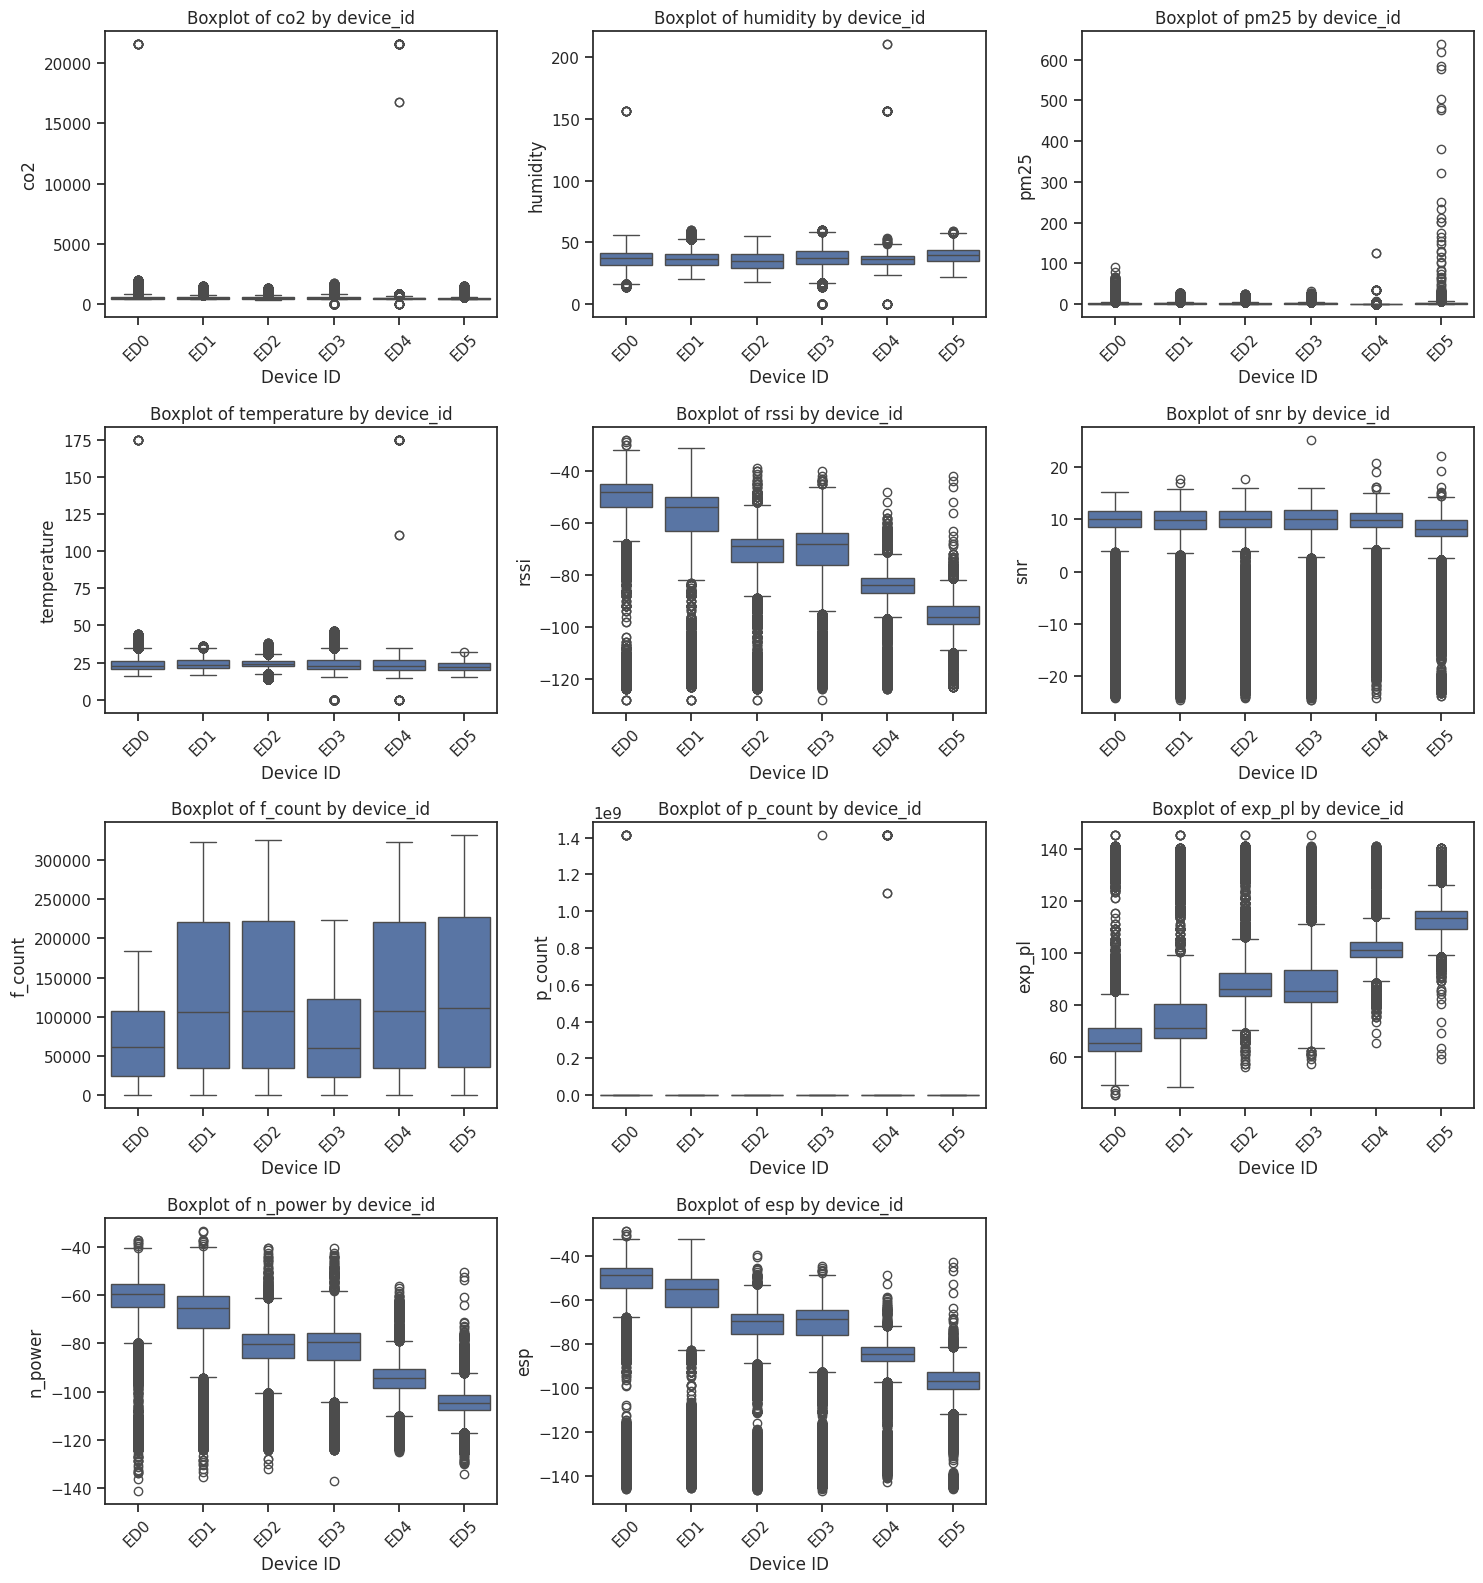

In [45]:
# Columns to exclude
exclude_cols = ['c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df.loc[:, 'device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Packet Delivery Ratio (PDR)
</p>

In [46]:
# Remove rows with a p_count above 2M ('abnormal outlier')
cleaned_df = cleaned_df[~(cleaned_df['p_count'] > 2000000)]

# Grouping data by device_id
grouped = cleaned_df.groupby('device_id')

# Calculating the total sent and received packets
pdr_table = grouped.agg(
    total_sent_packets=('p_count', 'max'),
    received_packets=('f_count', 'max')
)

# Calculating the PDR
pdr_table['PDR (%)'] = (pdr_table['received_packets'] / pdr_table['total_sent_packets']) * 100

# Displaying the result as a table
pdr_table

,total_sent_packets,received_packets,PDR (%)
device_id,,,
ED0,"203,894.000","183,834.000",90.162
ED1,"363,581.000","322,406.000",88.675
ED2,"363,604.000","325,312.000",89.469
ED3,"251,677.000","223,788.000",88.919
ED4,"363,571.000","322,429.000",88.684
ED5,"363,712.000","331,375.000",91.109


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Channel Usage Transmissions Confirmation / Check
</p>

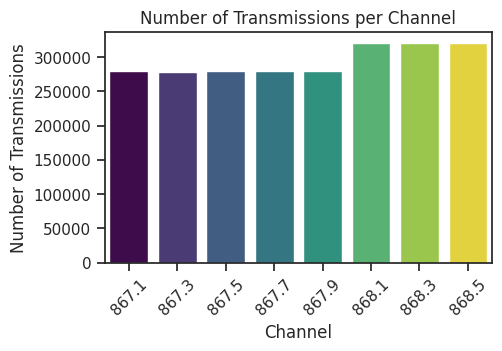

In [47]:
# Count transmissions per channel
channel_counts = cleaned_df['frequency'].value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(5, 3))
sns.barplot(
    x=channel_counts.index,
    y=channel_counts.values,
    hue=channel_counts.index,      # 'x' to 'hue'
    palette='viridis',
    dodge=False,                  
    legend=False              
)
plt.title('Number of Transmissions per Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Transmissions')
plt.xticks(rotation=45)
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Visual Dataframe Cleaning
</p>

In [48]:
# Remove rows with a temperature above 80
cleaned_df = cleaned_df[~(cleaned_df['temperature'] > 80)]

# Remove rows with humidity below 100
cleaned_df = cleaned_df[~(cleaned_df['humidity'] > 100)]

# Remove rows with a CO2 above 5000
cleaned_df = cleaned_df[~(cleaned_df['co2'] > 5000)]

# Remove rows with a CO2 = 0
cleaned_df = cleaned_df[~(cleaned_df['co2'] == 0)]

# Save all data to csv
cleaned_df.to_csv('../all_data_files/visually_cleaned_df.csv', index=False)

# Display the cleaned Dataframe Info
print("\nInfo of Combined DataFrame:\n")
cleaned_df.info()


Info of Combined DataFrame:

<class 'pandas.core.frame.DataFrame'>
Index: 2359734 entries, 0 to 2359834
Data columns (total 20 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         object 
 1   device_id    object 
 2   co2          float64
 3   humidity     float64
 4   pm25         float64
 5   pressure     float64
 6   temperature  float64
 7   rssi         float64
 8   snr          float64
 9   SF           int64  
 10  frequency    float64
 11  f_count      float64
 12  p_count      float64
 13  toa          float64
 14  distance     int64  
 15  c_walls      int64  
 16  w_walls      int64  
 17  exp_pl       float64
 18  n_power      float64
 19  esp          float64
dtypes: float64(14), int64(4), object(2)
memory usage: 378.1+ MB


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
   BOX PLOTS after physical elimination of 'abnormal' anomalies
</p>

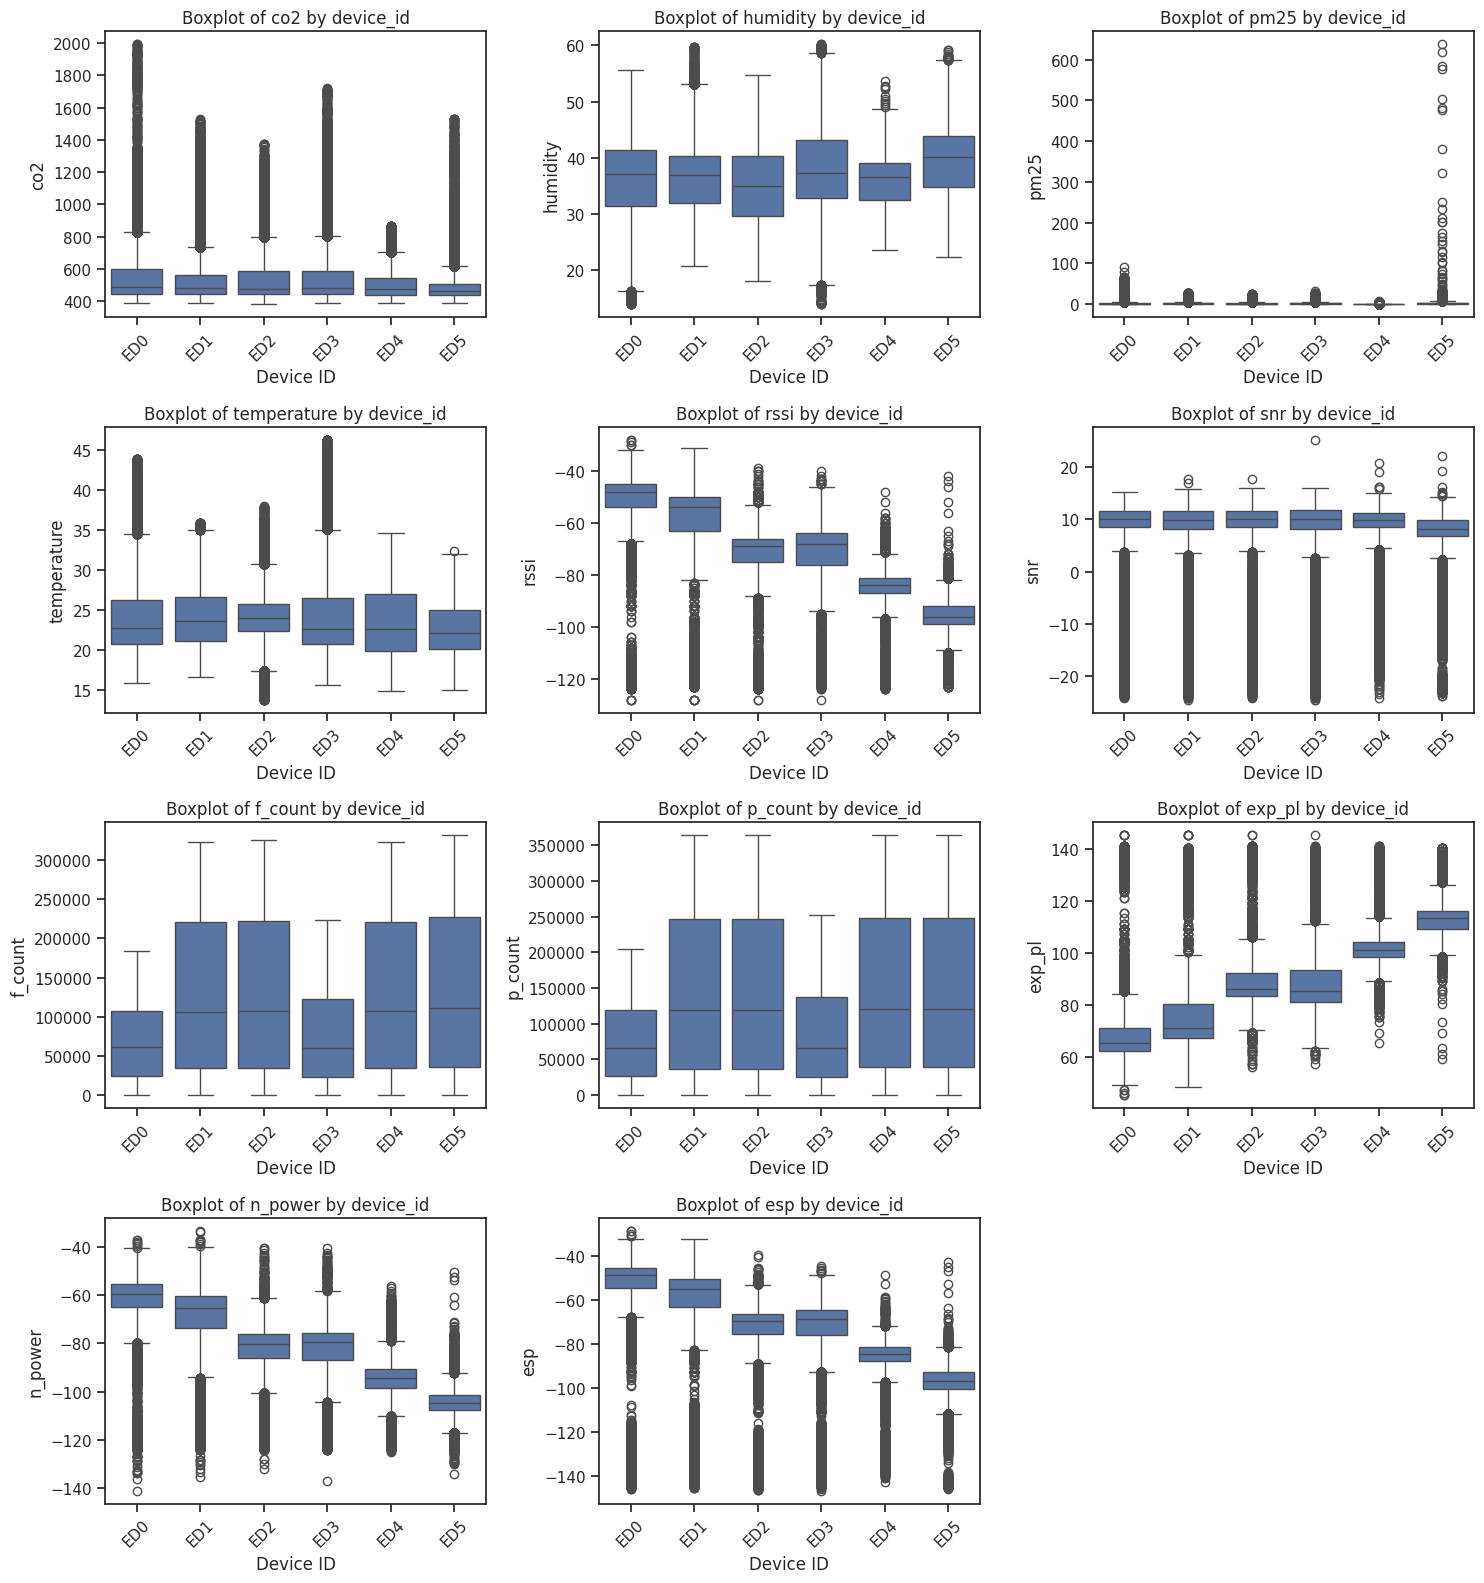

In [49]:
# Columns to exclude
exclude_cols = ['c_walls', 'w_walls', 'frequency', 'SF', 'toa', 'distance', 'pressure']

# Select numeric columns excluding 'f_count' and 'p_count'
numeric_cols = cleaned_df.select_dtypes(include=['float64', 'int64']).columns.drop(exclude_cols)

# Define the desired order for device_id
desired_order = ['ED0', 'ED1', 'ED2', 'ED3', 'ED4', 'ED5']

# Ensure 'device_id' is a categorical type with the specified order
cleaned_df.loc[:, 'device_id'] = pd.Categorical(cleaned_df['device_id'], categories=desired_order, ordered=True)

# Determine the number of plots
num_vars = len(numeric_cols)
cols = 3  # Number of columns in the subplot grid
rows = math.ceil(num_vars / cols)

# Set the overall figure size
plt.figure(figsize=(cols * 5, rows * 4))

# Iterate over each numeric column and create a subplot
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, idx)
    sns.boxplot(x='device_id', y=col, data=cleaned_df, order=desired_order)
    plt.title(f'Boxplot of {col} by device_id')
    plt.xlabel('Device ID')
    plt.ylabel(col)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
  Plot for Some Dataframe variables over time
</p>

In [50]:
def plot_sensor_readings(cleaned_df, row_map):
    """
    Plots sensor readings by grouping devices and assigning colors dynamically.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data.
    - row_map (dict): Mapping of sensor parameters to subplot rows.
    """
    # Create subplots dynamically based on the row_map provided
    fig = make_subplots(
        rows=len(row_map), cols=1, 
        subplot_titles=[f'{param.title()} Readings Over Time' for param in row_map]
    )

    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['green', 'red', 'blue', 'purple', 'orange', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])
    
    # Group by unique device IDs and assign colors dynamically
    device_colors = {device: next(color_pool) for device in cleaned_df['device_id'].unique()}

    # Set to track which devices have already been added to the legend
    devices_in_legend = set()

    # Plotting for each parameter and each device
    for param, row in row_map.items():
        for device, color in device_colors.items():
            # Filter data for the specific device
            data = cleaned_df[cleaned_df['device_id'] == device]
            
            # Add a trace for each parameter for the current device
            fig.add_trace(
                go.Scatter(
                    x=data['time'], 
                    y=data[param], 
                    mode='lines',  # Line plot
                    name=f"{device}" if device not in devices_in_legend else None,  # Device to legend once
                    line=dict(color=color),
                    showlegend=device not in devices_in_legend  # Show legend if the device hasn't been added yet
                ),
                row=row, col=1  # Place in the correct subplot
            )

            # Mark the device as added to the legend
            devices_in_legend.add(device)

    # Update layout with fixed height and other settings
    fig.update_layout(
        height=2400,  # Fixed height to accommodate all subplots
        showlegend=True,  # Show legend
        title_text="Sensor Readings Over Time",  # Overall plot title
        legend=dict(title="Devices", x=1.05, y=1)  # Adjusting legend position
    )

    # Show the plot
    fig.show()

In [51]:
# Plotting the dataset to check the trend for the last n days
n = 150  # Number of days to plot

cleaned_df['time'] = pd.to_datetime(cleaned_df['time'])  # Ensure 'time' is datetime
last_time = cleaned_df['time'].max()
start_time = last_time - pd.Timedelta(days=n)
df_last_n_days = cleaned_df[(cleaned_df['time'] >= start_time) & (cleaned_df['time'] <= last_time)]

row_map = {
    'temperature': 1, 'humidity': 2, 'co2': 3, 'pm25': 4,
    'pressure': 5, 'rssi': 6, 'snr': 7
}

#plot_sensor_readings(df_last_n_days, row_map)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Statistical Description
</p>

In [52]:
# Generate statistical description and remove unnecessary columns
stat_description = cleaned_df.describe().transpose().drop(
    columns=['count']).drop(['f_count', 'p_count'])

# Define the exact order of metrics and units for alignment
metrics = [
    'co2', 'humidity', 'pm25', 'pressure', 'temperature', 
    'rssi', 'snr', 'SF', 'frequency', 'toa', 
    'distance', 'c_walls', 'w_walls', 'exp_pl', 'n_power', 'esp'
]
units = [
    'ppm', '%', 'µg/m³', 'hPa', '°C', 'dBm', 'dB', 'bit/sym', 'MHz', 's', 
    'm', '', '', 'dB', 'dB', 'dBm'
]

# Set index explicitly to ensure correct row order
stat_description = stat_description.loc[metrics]

# Add units as a separate column
stat_description.insert(0, 'Unit', units)

# Rename columns accordingly
stat_description = stat_description.rename(columns={
    'mean': 'Mean',
    'std': 'STD (σ)',
    'min': 'Min',
    '25%': '1ˢᵗ Quartile (25%)', 
    '50%': 'Median', 
    '75%': '3ʳᵈ Quartile (75%)',
    'max': 'Max'
})

# Add "Field" as a regular column to align with other columns
stat_description.reset_index(inplace=True)
stat_description = stat_description.rename(columns={'index': 'Field'})

# Remove the automatic index numbering in the output
stat_description.index = [''] * len(stat_description)

# Format floating-point numbers to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Save to Excel file without automatic indices
excel_path = "statistical_description.xlsx"
stat_description.to_excel(excel_path, index=False)

# Display the updated statistical description
stat_description

,Field,Unit,Mean,STD (σ),Min,1ˢᵗ Quartile (25%),Median,3ʳᵈ Quartile (75%),Max
,co2,ppm,521.250,120.346,381.000,442.000,476.000,561.000,1993.000
,humidity,%,36.896,6.429,13.960,32.210,37.120,41.230,60.190
,pm25,µg/m³,2.148,2.621,0.000,0.720,1.400,2.630,637.710
,pressure,hPa,322.813,8.881,286.910,317.950,323.300,329.070,347.570
,temperature,°C,23.517,3.820,13.740,20.780,22.870,26.160,46.290
,rssi,dBm,-75.869,22.384,-128.000,-92.000,-72.000,-58.000,-28.000
,snr,dB,7.729,6.771,-24.500,8.000,9.500,11.200,25.200
,SF,bit/sym,9.203,1.642,7.000,8.000,9.000,10.000,12.000
,frequency,MHz,867.826,0.461,867.100,867.500,867.900,868.300,868.500
,toa,s,0.508,0.560,0.072,0.134,0.247,0.453,1.974


<Figure size 2000x2000 with 0 Axes>

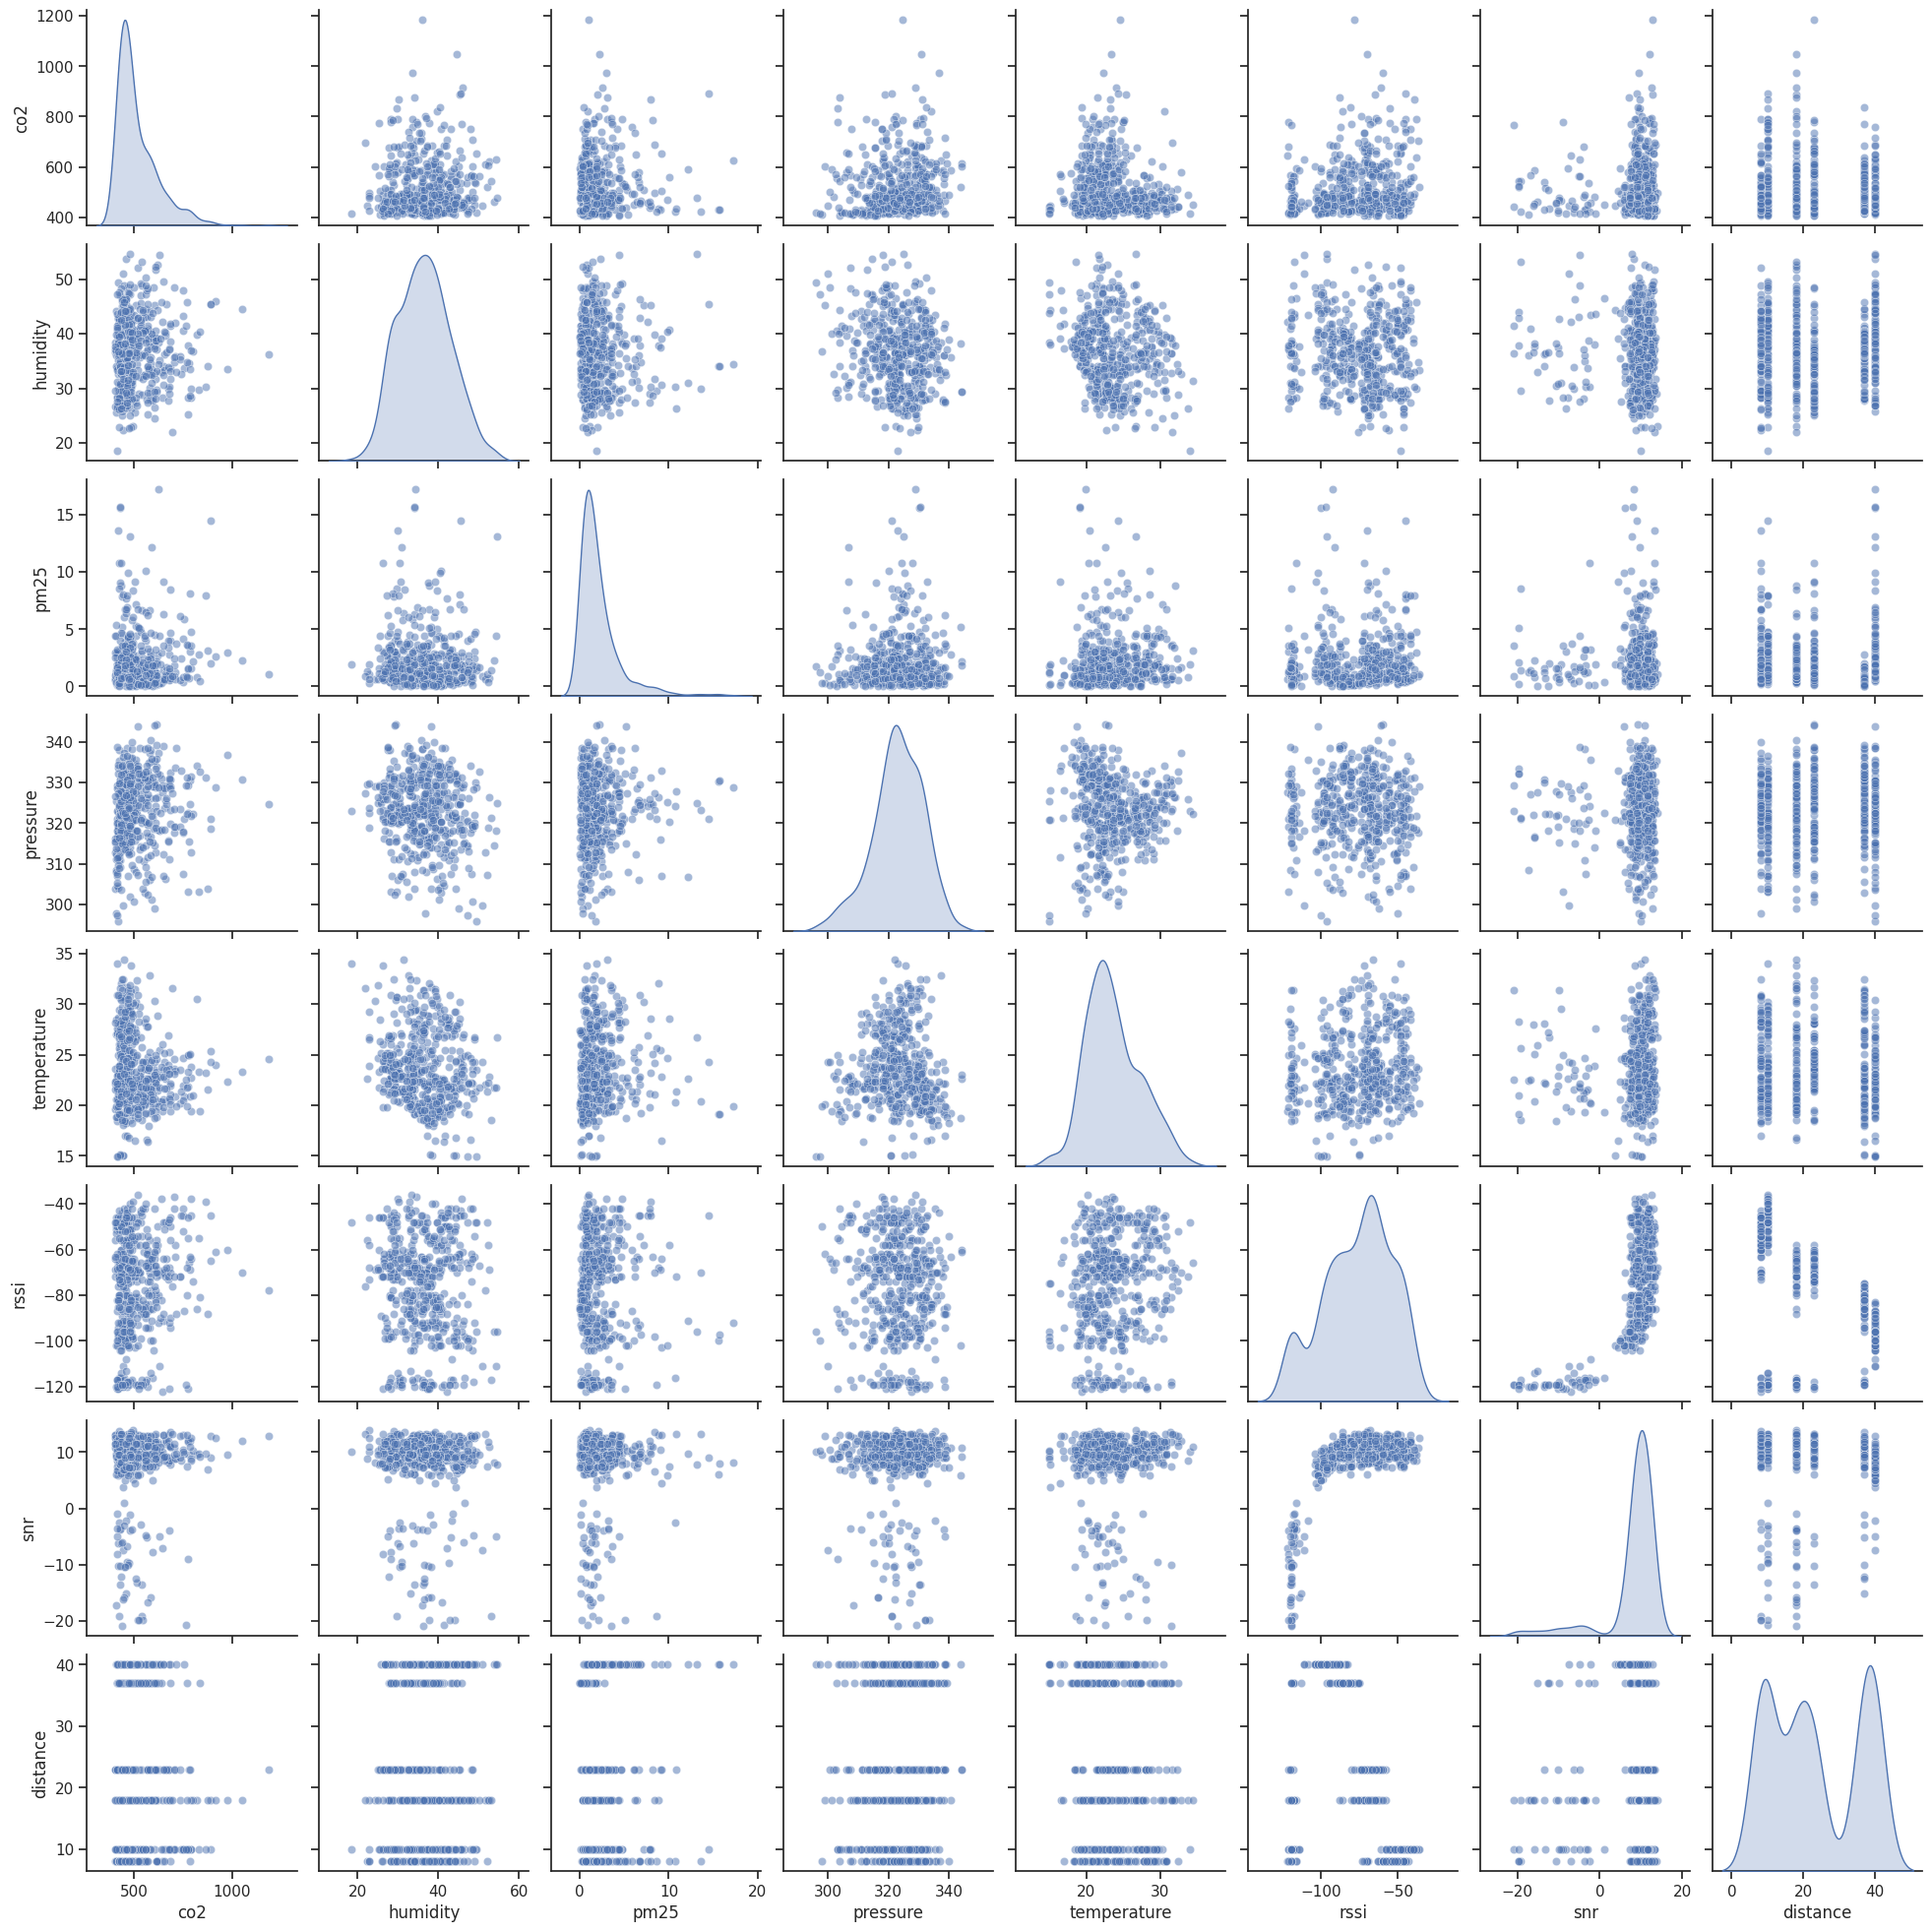

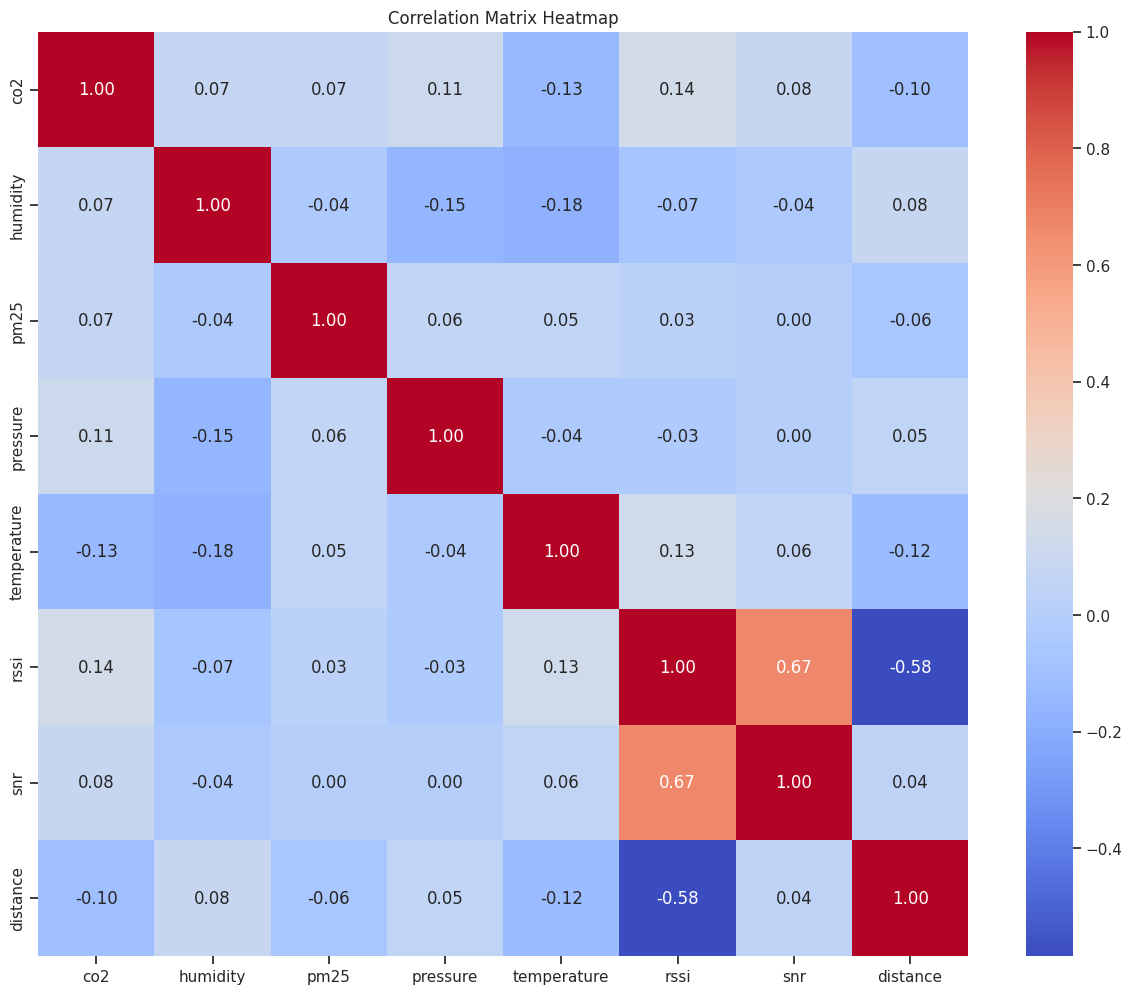

In [53]:
# Sample the DataFrame
sample_size = 500
cleaned_df_sample = cleaned_df.sample(n=sample_size, random_state=42)

# Select Numerical Columns
numerical_cols = [
    'co2', 'humidity', 'pm25', 'pressure', 'temperature',
    'rssi', 'snr', 'distance'
]
numerical_cols = [col for col in numerical_cols if col in cleaned_df_sample.columns]
pairplot_df = cleaned_df_sample[numerical_cols]

# Create Pair Plot
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(20, 20))
pair_plot = sns.pairplot(pairplot_df, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

# Correlation Heatmap
corr_matrix = pairplot_df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold;
color: blue;  text-align: left;">
  Overal Correlation Matrix
</p>

In [54]:
# Select only the numeric columns
numeric_df = cleaned_df.select_dtypes(include='number')

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set the display format for floating-point numbers to xx decimal places
pd.options.display.float_format = '{:,.3f}'.format 

# Display the Correlation Matrix
correlation_matrix

,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
co2,1.000,0.040,0.037,0.138,-0.151,0.058,-0.022,0.036,0.004,-0.131,-0.128,0.043,-0.117,-0.051,-0.083,-0.058,0.066,0.047
humidity,0.040,1.000,-0.004,-0.090,-0.195,-0.042,0.032,-0.028,-0.003,-0.365,-0.367,-0.032,0.091,0.198,-0.013,0.042,-0.048,-0.031
pm25,0.037,-0.004,1.000,0.084,0.127,0.005,-0.005,-0.015,-0.002,0.052,0.047,-0.018,-0.053,0.224,-0.212,-0.005,0.010,0.006
pressure,0.138,-0.090,0.084,1.000,-0.035,-0.020,-0.007,0.013,0.001,0.011,0.012,0.015,0.033,-0.027,0.058,0.020,-0.020,-0.019
temperature,-0.151,-0.195,0.127,-0.035,1.000,0.107,0.062,-0.095,-0.012,0.198,0.192,-0.111,-0.087,-0.070,-0.021,-0.107,0.106,0.103
rssi,0.058,-0.042,0.005,-0.020,0.107,1.000,0.681,-0.297,-0.009,-0.118,-0.116,-0.366,-0.560,-0.297,-0.420,-1.000,0.992,0.993
snr,-0.022,0.032,-0.005,-0.007,0.062,0.681,1.000,-0.383,-0.072,-0.046,-0.048,-0.506,0.036,-0.019,0.031,-0.681,0.594,0.756
SF,0.036,-0.028,-0.015,0.013,-0.095,-0.297,-0.383,1.000,0.073,0.060,0.062,0.899,0.002,0.003,-0.001,0.297,-0.270,-0.325
frequency,0.004,-0.003,-0.002,0.001,-0.012,-0.009,-0.072,0.073,1.000,0.008,0.009,0.082,0.002,0.003,-0.000,0.009,0.007,-0.014
f_count,-0.131,-0.365,0.052,0.011,0.198,-0.118,-0.046,0.060,0.008,1.000,1.000,0.072,0.162,0.069,0.114,0.118,-0.120,-0.111


In [55]:
#Single out PL and sort the values
numeric_df.corr()['exp_pl'].sort_values()

rssi          -1.000
esp           -0.993
n_power       -0.992
snr           -0.681
temperature   -0.107
co2           -0.058
pm25          -0.005
frequency      0.009
pressure       0.020
humidity       0.042
p_count        0.116
f_count        0.118
c_walls        0.297
SF             0.297
toa            0.366
w_walls        0.420
distance       0.560
exp_pl         1.000
Name: exp_pl, dtype: float64

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Scatter Plots : SNR vs RSSI for each Devices
</p>

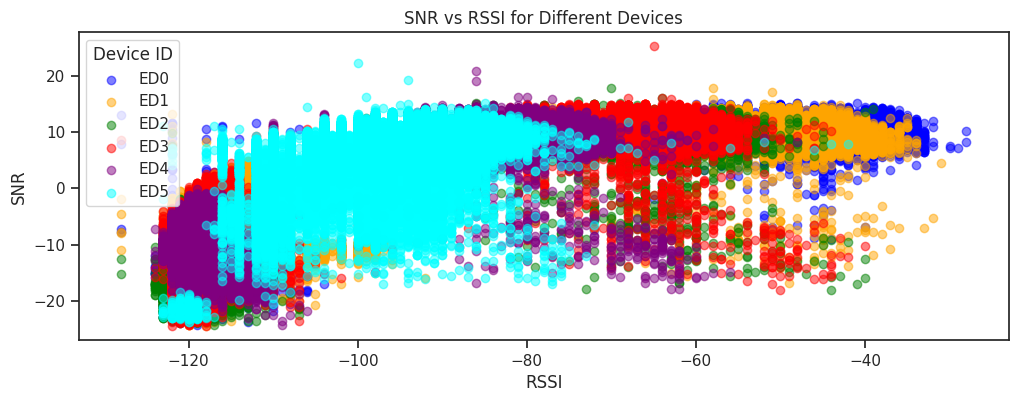

In [56]:
def plot_snr_vs_rssi(cleaned_df):
    """
    Plots SNR vs RSSI for each device dynamically using different colors.

    Args:
    - cleaned_df (DataFrame): Cleaned DataFrame containing sensor data with 'rssi' and 'snr' columns.
    """
    # Define a pool of colors and create an iterator to cycle through them
    color_pool = itertools.cycle(['blue', 'orange', 'green', 'red', 'purple', 
                                  'cyan', 'magenta', 'brown', 'black', 'pink'])

    # Create a figure for plotting
    plt.figure(figsize=(12, 4))

    # Group by unique device IDs and assign colors dynamically
    for device, color in zip(cleaned_df['device_id'].unique(), color_pool):
        # Filter data for each device
        subset = cleaned_df[cleaned_df['device_id'] == device]
        # Scatter plot for SNR vs RSSI
        plt.scatter(subset['rssi'], subset['snr'], label=device, color=color, alpha=0.5)

    # Add labels, legend, and title
    plt.xlabel('RSSI')
    plt.ylabel('SNR')
    plt.legend(title='Device ID', loc='upper left')
    plt.title('SNR vs RSSI for Different Devices')

    # Show the plot
    plt.show()

# Example usage:
plot_snr_vs_rssi(cleaned_df)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Exploration of LoRAWAN Parameters based on the Spreading Factor
</p>

In [57]:
# Calculate the mean of rssi, snr and exp_pl grouped by device_id
mean_values = cleaned_df.groupby('device_id', observed=False)[['rssi', 'snr', 'exp_pl']].mean()

# Count each SF per device
sf_counts = (
    cleaned_df.groupby(['device_id', 'SF'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=range(7, 13), fill_value=0)  # SF7 to SF12
)

# Rename columns to SF7, SF8, ... SF12
sf_counts.columns = [f'SF{sf}' for sf in sf_counts.columns]

# Merge counts with the original mean_values table
extended_df = mean_values.join(sf_counts, how='left')

# Display the result
extended_df

,rssi,snr,exp_pl,SF7,SF8,SF9,SF10,SF11,SF12
device_id,,,,,,,,,
ED0,-57.480,7.607,74.740,76742,76381,73996,71184,47158,48403
ED1,-63.586,7.392,80.846,76570,75905,73121,69825,46061,47783
ED2,-74.090,8.211,91.350,77139,76788,74220,71275,46962,48108
ED3,-76.519,7.120,93.779,76111,75451,72439,69856,46668,47990
ED4,-86.998,8.122,104.258,76607,76113,73088,69376,46122,47823
ED5,-95.999,7.909,113.259,77367,77572,76280,75450,48820,48980


In [58]:
# Filter for SF11 and SF12
sf_special = cleaned_df[cleaned_df['SF'].isin([11, 12])]

# Format the timestamps to 'YYYY-MM-DD HH:MM:SS'
sf_special = sf_special.copy()
sf_special['time_str'] = sf_special['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Aggregate the formatted times into lists per device and SF
sf_agg = (
    sf_special
    .groupby(['device_id', 'SF'])['time_str']
    .apply(list)
    .reset_index()
)

# Display the result
print("All times as list per device and SF (up to seconds):")
sf_agg

All times as list per device and SF (up to seconds):


,device_id,SF,time_str
0,ED0,11,"[2024-09-26 11:19:11, 2024-09-26 11:20:11, 202..."
1,ED0,12,"[2024-09-26 11:13:10, 2024-09-26 11:14:10, 202..."
2,ED1,11,"[2024-09-26 11:51:28, 2024-09-26 11:52:28, 202..."
3,ED1,12,"[2024-09-26 11:15:16, 2024-09-26 11:45:27, 202..."
4,ED2,11,"[2024-09-26 11:15:27, 2024-09-26 11:16:27, 202..."
5,ED2,12,"[2024-09-26 11:09:26, 2024-09-26 11:10:26, 202..."
6,ED3,11,"[2024-09-26 11:22:56, 2024-09-26 11:23:56, 202..."
7,ED3,12,"[2024-09-26 11:16:54, 2024-09-26 11:17:54, 202..."
8,ED4,11,"[2024-09-26 11:14:30, 2024-09-26 11:15:30, 202..."
9,ED4,12,"[2024-09-26 11:08:28, 2024-09-26 11:09:28, 202..."


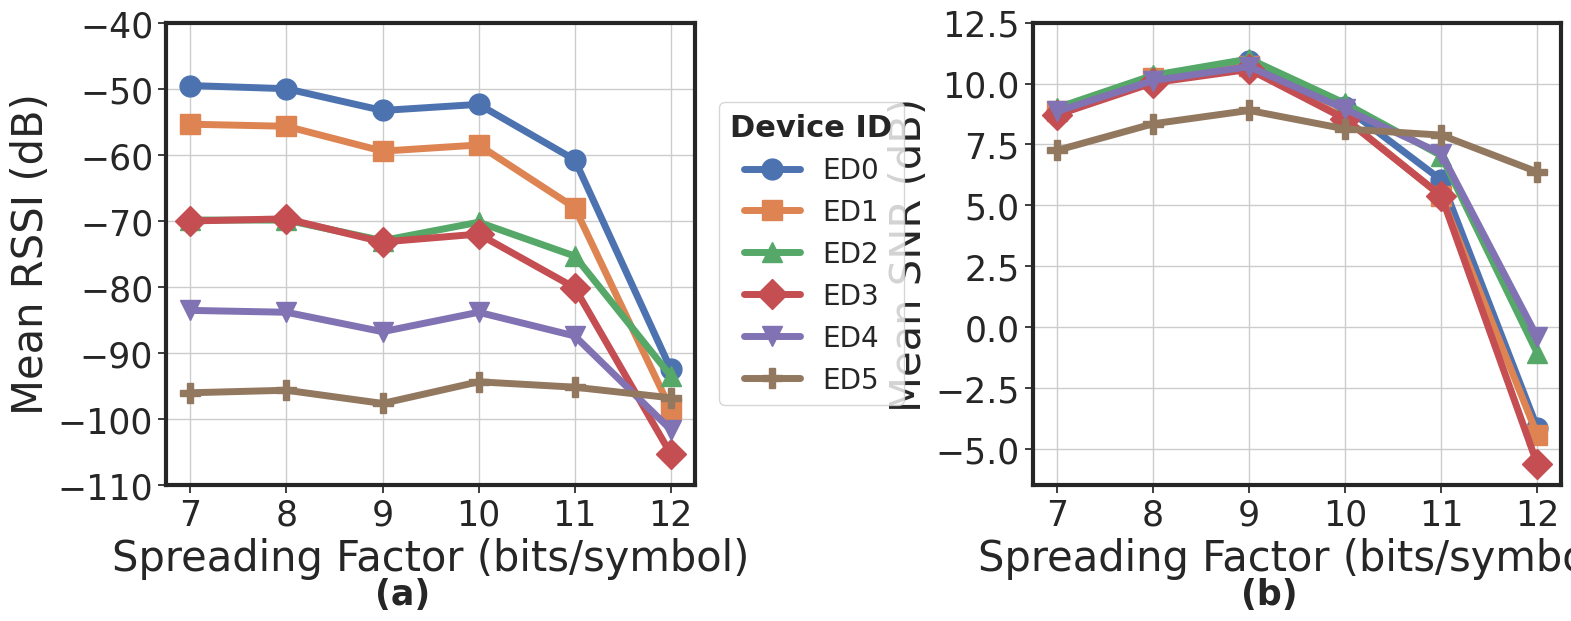

In [59]:
def plot_mean_metric(ax, cleaned_df, metric, ylabel, label=''):
    """
    Plots the mean of a specified metric grouped by Spreading Factor (SF) for each device.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - cleaned_df (DataFrame): DataFrame containing sensor data with 'device_id', 'SF', and metric columns.
    - metric (str): The metric to plot (e.g., 'rssi', 'snr', 'toa').
    - ylabel (str): The label for the y-axis.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of markers to use for different devices
    marker_pool = itertools.cycle(['o', 's', '^', 'D', 'v', 'P', '*'])
    
    # Group by device and calculate mean metric for each SF
    for device_id, device_data in cleaned_df.groupby('device_id', observed=False):
        mean_metric = device_data.groupby('SF', observed=False)[metric].mean()
        # Plot mean metric for each device with a different marker
        ax.plot(mean_metric.index, mean_metric.values, marker=next(marker_pool), linestyle='-', markersize=15, linewidth=5, label=device_id)
    
    # Set axis labels with increased font size
    ax.set_xlabel('Spreading Factor (bits/symbol)', fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.grid(True)
    
    # Set tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=25)
     
    # Set specific tick positions on the x-axis
    ax.set_xticks([7, 8, 9, 10, 11, 12]) 

    # Set border (axes spine) linewidth to 3
    for spine in ax.spines.values():
        spine.set_linewidth(3)
    
    # Add subplot label (e.g., '(a)') with increased font size
    ax.text(0.5, -0.2, label, transform=ax.transAxes, fontsize=25, fontweight='bold', va='top', ha='right')

# Set up the matplotlib figure with GridSpec to allocate space for the legend
fig = plt.figure(figsize=(18, 6)) 

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 1], wspace=0.3)

# Add subplots for RSSI and SNR
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 2])


# Define subplot labels
subplot_labels = ['(a)', '(b)']

# Plot mean RSSI
plot_mean_metric(ax1, cleaned_df, 'rssi', 'Mean RSSI (dB)', label=subplot_labels[0])

# Plot mean SNR
plot_mean_metric(ax2, cleaned_df, 'snr', 'Mean SNR (dB)', label=subplot_labels[1])

# Collect handles and labels from both subplots
handles_a, labels_a = ax1.get_legend_handles_labels()
handles_b, labels_b = ax2.get_legend_handles_labels()

# Set specific tick positions on the y-axis
ax1.set_yticks([-110, -100, -90, -80, -70, -60, -50, -40])  
ax2.set_yticks([-5, -2.5, -0, 2.5, 5, 7.5, 10, 12.5]) 

# Combine handles and labels, ensuring uniqueness
unique = OrderedDict()
for label, handle in zip(labels_a + labels_b, handles_a + handles_b):
    if label not in unique:
        unique[label] = handle
handles, labels = unique.values(), unique.keys()

# Create a separate axis for the legend in the middle column
legend_ax = fig.add_subplot(gs[0, 1])
legend_ax.axis('off')  # Hide the axis

# Add the common legend to the legend axis
legend = legend_ax.legend(
    handles, labels, 
    title='Device ID', 
    fontsize=20, 
    title_fontsize=22, 
    loc='center left',  
    bbox_to_anchor=(-1.0, 0.5), 
    ncol=1
)

legend.get_title().set_fontweight('bold')

# Adjust layout to ensure everything fits without overlapping
# plt.tight_layout()

# Save the figure 
plt.savefig('../all_data_files/rssi_and_snr_per_SF.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 KDE Plots: Environmental Parameters & LoRaWAN Signal PARAMETERS
</p>

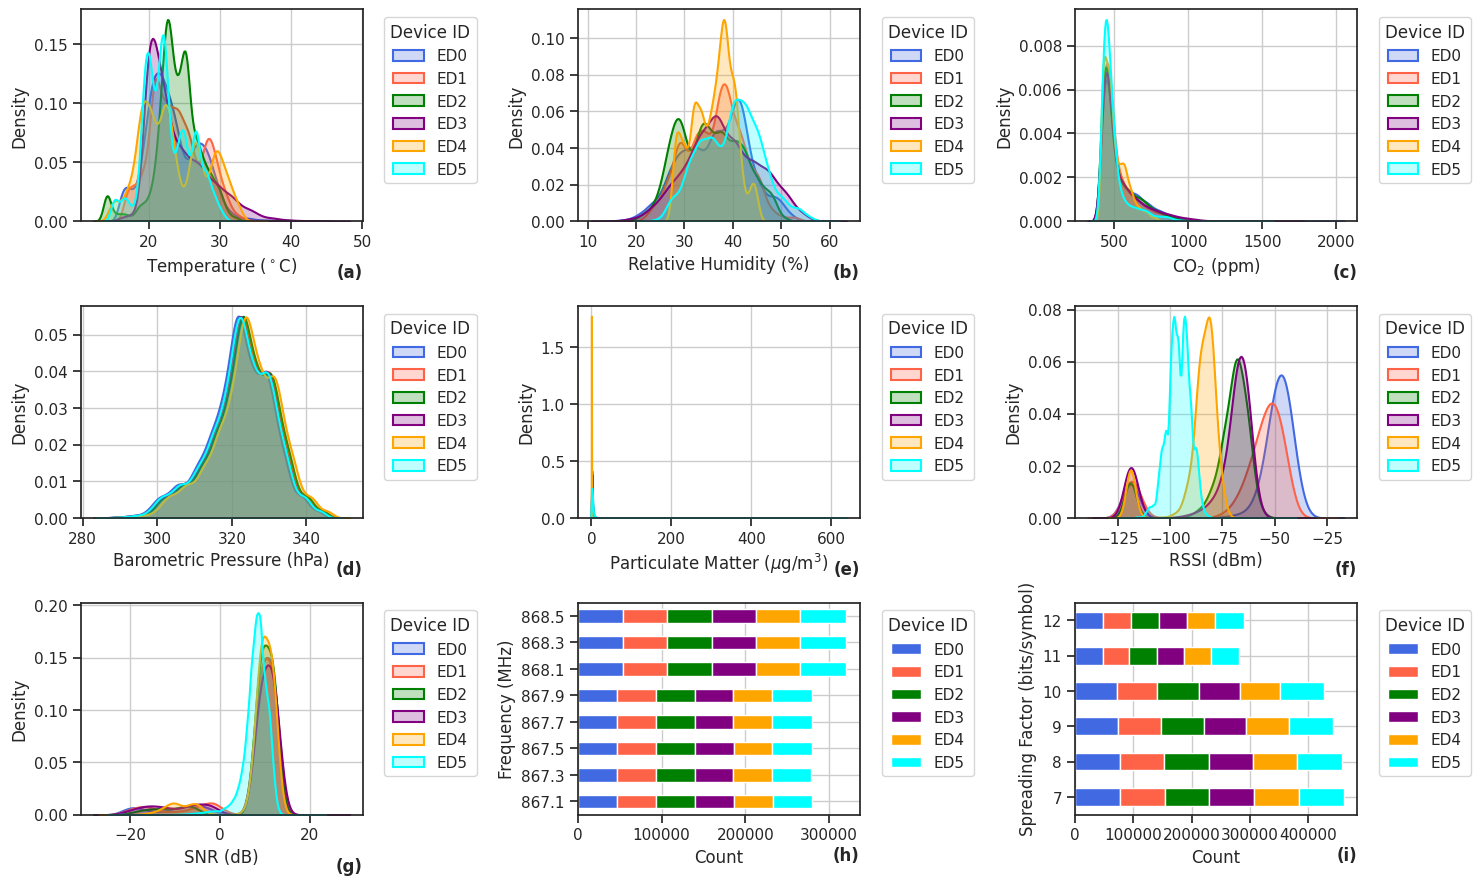

In [60]:
# Define labels with units and formatting
labels = {
    'temperature': r'Temperature ($^\circ$C)',
    'humidity': r'Relative Humidity (%)',
    'co2': r'CO$_2$ (ppm)',
    'pressure': r'Barometric Pressure (hPa)',
    'pm25': r'Particulate Matter ($\mu$g/m$^3$)',
    'rssi': r'RSSI (dBm)',
    'snr': r'SNR (dB)',
    'frequency': r'Frequency (MHz)',
    'SF': r'Spreading Factor (bits/symbol)',
}


def plot_stacked_bar(ax, data, parameter, label=''):
    """
    Plots a stacked bar chart for the given parameter, grouping by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'frequency', 'SF', 'distance').
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colors to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Pivot the data to have device_id as columns
    pivot_data = data.pivot_table(index=parameter, columns='device_id', aggfunc='size', fill_value=0, observed=False)
    
    # Sort device_ids alphabetically
    device_ids = sorted(pivot_data.columns)
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device: next(color_pool) for device in device_ids}

    # Plot the stacked bar plot
    pivot_data[device_ids].plot(kind='barh', stacked=True, ax=ax, color=[colors[device] for device in device_ids])
    
    ax.set_xlabel('Count')
    ax.set_ylabel(labels[parameter])
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_labels, sorted_handles = zip(*sorted(zip(labels_, handles)))
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add subplot label
    ax.text(1, -0.15, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

def plot_kde(ax, data, parameter, bw_adjust=2, label=''):
    """
    Plots a Kernel Density Estimate (KDE) for the given parameter, grouped by 'device_id'.

    Args:
    - ax (Axes): Matplotlib Axes object to plot on.
    - data (DataFrame): DataFrame containing sensor data with 'device_id' and the parameter to plot.
    - parameter (str): The parameter to plot (e.g., 'temperature', 'humidity', 'co2').
    - bw_adjust (float): Bandwidth adjustment for the KDE plot.
    - label (str): The subplot label (e.g., '(a)')
    """
    # Define a pool of colours to use for different devices
    color_pool = itertools.cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 'cyan', 'magenta'])
    
    # Get sorted device_ids
    device_ids = sorted(data['device_id'].unique())
    
    # Create a color map dynamically based on sorted device_ids
    colors = {device_id: next(color_pool) for device_id in device_ids}
    
    # Plot KDE for each device, sorted by device_id
    for device_id in device_ids:
        subset = data[data['device_id'] == device_id]
        sns.kdeplot(
            subset[parameter], ax=ax, 
            label=device_id, 
            lw=1.5, 
            bw_adjust=bw_adjust, 
            fill=True, 
            color=colors[device_id]
        )
    
    ax.set_xlabel(labels[parameter])
    ax.set_ylabel('Density')
    ax.grid(True)
    
    # Sort the legend entries alphabetically
    handles, labels_ = ax.get_legend_handles_labels()
    sorted_labels, sorted_handles = zip(*sorted(zip(labels_, handles)))
    ax.legend(sorted_handles, sorted_labels, title='Device ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add subplot label
    ax.text(1, -0.2, label, transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=12)

# Filter the DataFrame
filtered_df = cleaned_df[cleaned_df['device_id'].isin(cleaned_df['device_id'].unique())]

# Set up the matplotlib figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))  # Increased figure height for better spacing

# Define subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

# Plot each parameter on a separate subplot with corresponding labels
plot_kde(axes[0, 0], filtered_df, 'temperature', bw_adjust=2, label=subplot_labels[0])
plot_kde(axes[0, 1], filtered_df, 'humidity', bw_adjust=2, label=subplot_labels[1])
plot_kde(axes[0, 2], filtered_df, 'co2', bw_adjust=2, label=subplot_labels[2])
plot_kde(axes[1, 0], filtered_df, 'pressure', bw_adjust=2, label=subplot_labels[3])
plot_kde(axes[1, 1], filtered_df, 'pm25', bw_adjust=2, label=subplot_labels[4])
plot_kde(axes[1, 2], filtered_df, 'rssi', bw_adjust=2, label=subplot_labels[5])
plot_kde(axes[2, 0], filtered_df, 'snr', bw_adjust=2, label=subplot_labels[6])

# Plot the stacked bar charts on the last two subplots with corresponding labels
plot_stacked_bar(axes[2, 1], filtered_df, 'frequency', label=subplot_labels[7])
plot_stacked_bar(axes[2, 2], filtered_df, 'SF', label=subplot_labels[8])

# Ensure proper spacing between rows by adjusting the layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Space between rows

# Save the figure
plt.savefig('../all_data_files/signal_environmental_dist.png', dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LoRaWAN Effective Signal Power vs Noise Power
</p>

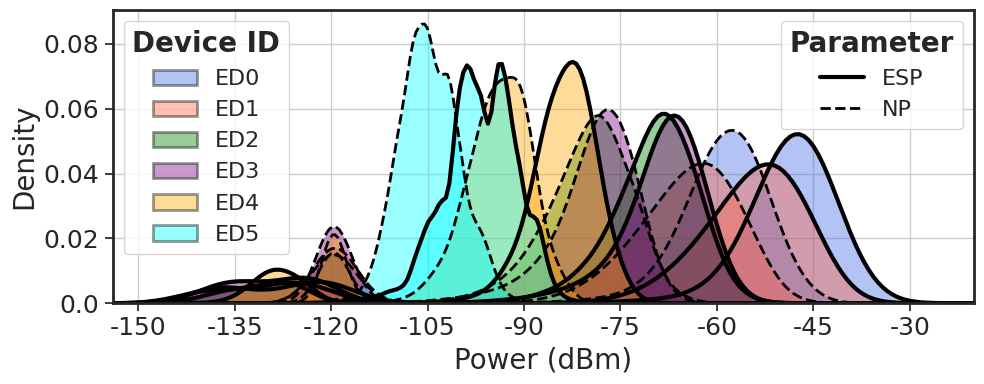

In [61]:
def plot_esp_n_power_comparison(ax, data, bw_adjust=2, title='ESP vs N_Power Distribution per Device'):
    """
    Compare 'esp' and 'n_power' distributions per device using KDE plots.
    KDE lines are drawn in black while the fill remains in the device's color.
    """
    # Assign colors to each device
    color_pool = cycle(['royalblue', 'tomato', 'green', 'purple', 'orange', 
                        'cyan', 'magenta', 'brown', 'olive', 'pink'])
    devices = sorted(data['device_id'].unique())
    colors = {device: next(color_pool) for device in devices}
    
    for device in devices:
        subset = data[data['device_id'] == device]
        
        # --- ESP: fill only ---
        sns.kdeplot(
            subset['esp'], ax=ax, lw=0, bw_adjust=bw_adjust,
            color=colors[device], fill=True, alpha=0.4, label=None
        )
        # --- ESP: black outline ---
        sns.kdeplot(
            subset['esp'], ax=ax, lw=3, bw_adjust=bw_adjust,
            color='black', linestyle='-', fill=False, label=f'{device} - ESP'
        )
        
        # --- N_Power: fill only ---
        sns.kdeplot(
            subset['n_power'], ax=ax, lw=0, bw_adjust=bw_adjust,
            color=colors[device], fill=True, alpha=0.4, label=None
        )
        # --- N_Power: black outline ---
        sns.kdeplot(
            subset['n_power'], ax=ax, lw=2, bw_adjust=bw_adjust,
            color='black', linestyle='--', fill=False, label=f'{device} - N_Power'
        )
    
    # Axes labels and grid
    ax.set_xlabel('Power (dBm)', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.grid(True)

    # Custom ticks
    ax.set_xticks(range(-150, -19, 15))
    ax.set_xticklabels(range(-150, -19, 15), fontsize=18)
    ax.set_yticks([0.0, 0.02, 0.04, 0.06, 0.08])
    ax.set_yticklabels(['0.0', '0.02', '0.04', '0.06', '0.08'], fontsize=18)
    
    ax.set_xlim(-154, -20)

      # Set border (axes spine) linewidth to 2
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    
    # =============== Legends ===============
    # 1) Device legend: Patch with same alpha as ESP fill (0.3), black edge
    device_handles = [
        Patch(facecolor=colors[device], alpha=0.4, edgecolor='black', linewidth=2)
        for device in devices
    ]
    device_labels = devices
    
    # 2) Parameter legend: black lines, solid/dashed
    parameter_handles = [
        Line2D([0], [0], color='black', lw=3, linestyle='-'),
        Line2D([0], [0], color='black', lw=2, linestyle='--')
    ]
    parameter_labels = ['ESP', 'NP']
    
    # Device ID legend: top-left
    legend1 = ax.legend(
        device_handles, device_labels, title='Device ID',
        loc='upper left', fontsize=16, title_fontsize=20
    )
    legend1.get_title().set_fontweight('bold')
    ax.add_artist(legend1)
    
    # Parameter legend: top-right
    legend2 = ax.legend(
        parameter_handles, parameter_labels, title='Parameter',
        loc='upper right', fontsize=16, title_fontsize=20
    )
    legend2.get_title().set_fontweight('bold')

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 4))
plot_esp_n_power_comparison(ax, filtered_df, bw_adjust=2, title='ESP vs N_Power Distribution per Device')
plt.tight_layout()

# Save the plot
plt.savefig('../all_data_files/esp_n_power_comparison.png', dpi=1000)

# Display the plot
plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 .....................#........................
</p>